In [395]:
import re
import pandas as pd
from datetime import datetime

with open('access.log', 'r') as log_file:
    log_lines = log_file.readlines()

In [396]:
def parse_logs(lines):
    log_data = []
    regex = r'(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] "(.*?)" (\d+) (\d+) "(.*?)" "(.*?)"'
    for line in lines:
        match = re.match(regex, line)
        if match:
            groups = match.groups()
            dt = datetime.strptime(groups[1], '%d/%b/%Y:%H:%M:%S %z')
            # request_info = groups[2].split()
            log_data.append({
                'IP': groups[0],
                'Date': dt.date(),
                'Time': dt.time(),
                'Request':  groups[2],
                'Status_Code': int(groups[3]),
                'Size': int(groups[4]),
                'Referer': groups[5],
                'User-Agent': groups[6]})
    return log_data

log_data = parse_logs(log_lines)
df = pd.DataFrame(log_data)

df.head(3)

,IP,Date,Time,Request,Status_Code,Size,Referer,User-Agent
0,136.145.136.38,2018-11-15,18:21:30,GET / HTTP/1.1,200,553,-,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...
1,136.145.136.38,2018-11-15,18:21:31,GET /icons/blank.gif HTTP/1.1,200,395,http://proyecto-oller.online/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...
2,136.145.136.38,2018-11-15,18:21:31,GET /favicon.ico HTTP/1.1,404,476,-,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...


In [397]:
# Визначити кількість користувачів за днями

df.groupby('Date')['IP'].nunique().reset_index(name='Unique_Users')

,Date,Unique_Users
0,2018-11-15,12
1,2018-11-16,17


In [398]:
# Ранжувати користувачів за User-Agent

df.groupby('User-Agent')['IP'].nunique().sort_values(ascending=False).reset_index(name='Unique_IP').head(10)


,User-Agent,Unique_IP
0,-,5
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,5
2,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,4
3,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,2
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...,2
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1...,2
6,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,2
7,Mozilla,2
8,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,1
9,Mozilla/5.0(WindowsNT6.1;rv:31.0)Gecko/2010010...,1


In [399]:
# Додавання колонки з ОС

from user_agents import parse

df['OS'] = df['User-Agent'].apply(lambda x: parse(x).os.family)
df['OS'].value_counts().reset_index(name='Count')


,index,Count
0,Mac OS X,233
1,Windows,72
2,iOS,69
3,Android,57
4,Other,19


In [400]:
# Ранжувати користувачів за операційними системами

df.groupby('OS')['IP'].nunique().sort_values(ascending=False).reset_index(name='Unique_IP')

,OS,Unique_IP
0,Windows,11
1,Mac OS X,10
2,Other,9
3,Android,2
4,iOS,2


In [401]:
# Додавання колонки з країнами

import geoip2.database

def get_country_by_ip(ip_address):
    reader = geoip2.database.Reader('GeoLite2-Country.mmdb')
    
    try:
        response = reader.country(ip_address)
        country_name = response.country.name
        return country_name
    except geoip2.errors.AddressNotFoundError:
        return None
    finally:
        reader.close()

df['Country'] = df['IP'].apply(get_country_by_ip)

df['Country'].value_counts().reset_index(name='Count')

,index,Count
0,Puerto Rico,350
1,United States,76
2,Vietnam,9
3,India,2
4,Germany,2
5,Taiwan,2
6,Brazil,2
7,China,2
8,South Korea,1
9,Norway,1


In [402]:
# Ранжувати користувачів за країною запиту

df.groupby('Country')['IP'].nunique().sort_values(ascending=False).reset_index(name='Unique_IP')

,Country,Unique_IP
0,Puerto Rico,8
1,United States,7
2,Brazil,2
3,India,2
4,Taiwan,2
5,China,1
6,Germany,1
7,Lithuania,1
8,Norway,1
9,South Korea,1


In [403]:
# Пошук ботів

def extract_bots(log_lines):
    bot_list = []
    bot_patterns = [
        'bot', 'crawler', 'spider', 'slurp', 'archiver', 'python', 'fetch', 'facebook', 'monitoring', 'http',
        'scan', 'checker', 'analyzer', 'apache', 'java', 'google', 'bing', 'yahoo', 'msn', 'baidu', 'yandex',
        'duckduckgo', 'seznam'
    ]
    
    user_agent_pattern = re.compile(r'".*?"\s+"([^"]+)"')
    
    for line in log_lines:
        match = user_agent_pattern.search(line)
        if match:
            user_agent = match.group(1).lower()
            if any(bot in user_agent for bot in bot_patterns):
                bot_list.append(user_agent)
    
    return list(set(bot_list))

bots = extract_bots(log_lines)
print(bots)


['mozilla/5.0 (compatible; mj12bot/v1.4.8; http://mj12bot.com/)', 'bot-pge.chlooe.com/1.0.0 (+http://www.chlooe.com/)']


In [404]:
# Виокремити пошукових ботів

bots = ['mj12bot', 'chlooe']

df['Bot'] = df['User-Agent'].apply(lambda x: next((bot for bot in bots if bot in x), None))

df['Bot'].value_counts().reset_index(name='Count')

,index,Count
0,mj12bot,2
1,chlooe,1


In [405]:
df.head(5)

,IP,Date,Time,Request,Status_Code,Size,Referer,User-Agent,OS,Country,Bot
0,136.145.136.38,2018-11-15,18:21:30,GET / HTTP/1.1,200,553,-,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,Mac OS X,Puerto Rico,None
1,136.145.136.38,2018-11-15,18:21:31,GET /icons/blank.gif HTTP/1.1,200,395,http://proyecto-oller.online/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,Mac OS X,Puerto Rico,None
2,136.145.136.38,2018-11-15,18:21:31,GET /favicon.ico HTTP/1.1,404,476,-,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,Mac OS X,Puerto Rico,None
3,103.93.21.233,2018-11-15,18:31:24,GET / HTTP/1.1,200,745,-,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Windows,India,None
4,123.31.30.209,2018-11-15,18:43:05,GET / HTTP/1.1,200,753,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows,Vietnam,None


In [406]:
df_anomaly = pd.DataFrame()

df_anomaly['IP'] = df['IP'].unique()
df_anomaly = df_anomaly.merge(df.groupby('IP')['Request'].count().reset_index(name = 'Requests_count'))

df['Success'] = df['Status_Code'].apply(lambda x: x in [200, 206])
df['Fail'] = df['Status_Code'].apply(lambda x: x in [404, 408])

df_anomaly = df_anomaly.merge(df.groupby('IP')['Success'].sum().reset_index(name = 'Success_count'))
df_anomaly = df_anomaly.merge(df.groupby('IP')['Fail'].sum().reset_index(name = 'Fail_count'))
df_anomaly = df_anomaly.merge(df.groupby('IP')['Size'].sum().reset_index(name = 'Size'))

df['Day'] = df['Time'].apply(lambda x: 6 <= x.hour < 20)
df['Night'] = df['Time'].apply(lambda x: 6 > x.hour or x.hour >= 20)

df_anomaly = df_anomaly.merge(df.groupby('IP')['Day'].sum().reset_index(name = 'Day_count'))
df_anomaly = df_anomaly.merge(df.groupby('IP')['Night'].sum().reset_index(name = 'Night_count'))

df_anomaly.head(5)

,IP,Requests_count,Success_count,Fail_count,Size,Day_count,Night_count
0,136.145.136.38,11,4,7,5413,11,0
1,103.93.21.233,1,1,0,745,1,0
2,123.31.30.209,9,2,7,4960,9,0
3,66.50.50.8,67,28,37,782192,63,4
4,136.145.136.10,9,3,6,4392,9,0


In [407]:
from sklearn.preprocessing import StandardScaler

df_anomaly_copy = df_anomaly.copy()
x = df_anomaly_copy.drop('IP', axis = 1)
y = df_anomaly_copy['IP']

x_scaled = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)
x_scaled.head(5)

,Requests_count,Success_count,Fail_count,Size,Day_count,Night_count
0,-0.156074,-0.242755,0.130091,-0.479435,-0.025381,-0.340777
1,-0.501580,-0.381700,-0.564870,-0.486137,-0.485414,-0.340777
2,-0.225175,-0.335385,0.130091,-0.480085,-0.117388,-0.340777
3,1.778763,0.868806,3.108496,0.635926,2.366787,0.002963
4,-0.225175,-0.289070,0.030811,-0.480901,-0.117388,-0.340777


In [408]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X2_pca  = pca.fit_transform(x_scaled)

X2_pca_df = pd.DataFrame({'pca_1': X2_pca[:,0], 'pca_2': X2_pca[:,1], 'IP': y})

X2_pca_df.head(3)

,pca_1,pca_2,IP
0,-0.468580,-0.350553,136.145.136.38
1,-1.120921,0.190400,103.93.21.233
2,-0.579816,-0.356143,123.31.30.209


<AxesSubplot: xlabel='pca_1', ylabel='pca_2'>

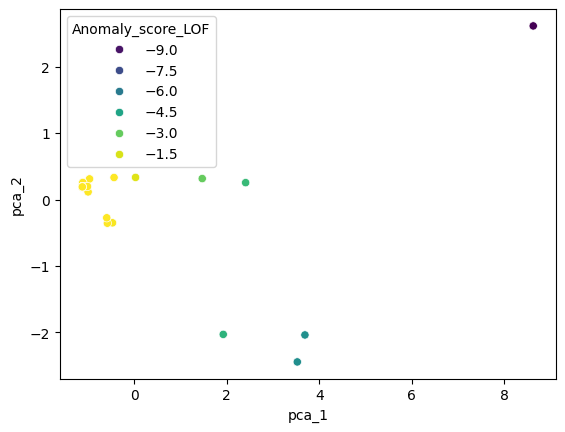

In [409]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

lof = LocalOutlierFactor(n_neighbors=20)
lof.fit(X2_pca)

anomaly_scores = lof.negative_outlier_factor_

X2_pca_df['Anomaly_score_LOF'] = anomaly_scores
sns.scatterplot(x='pca_1', y='pca_2', hue='Anomaly_score_LOF', palette='viridis', data=X2_pca_df)


<AxesSubplot: xlabel='pca_1', ylabel='pca_2'>

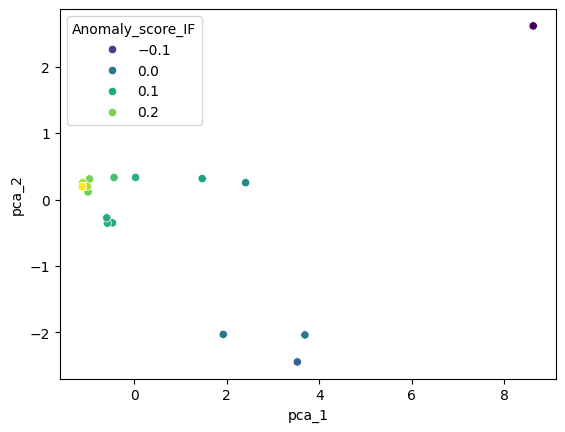

In [410]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.1)
isolation_forest.fit(X2_pca)
anomaly_scores = isolation_forest.decision_function(X2_pca)

X2_pca_df['Anomaly_score_IF'] = anomaly_scores

sns.scatterplot(x='pca_1', y='pca_2', hue='Anomaly_score_IF', palette='viridis', data=X2_pca_df)

In [412]:
X2_pca_df

,pca_1,pca_2,IP,Anomaly_score_LOF,Anomaly_score_IF
0,-0.468580,-0.350553,136.145.136.38,-1.081098,0.101081
1,-1.120921,0.190400,103.93.21.233,-0.997508,0.281216
2,-0.579816,-0.356143,123.31.30.209,-0.992755,0.116953
3,3.525601,-2.442663,66.50.50.8,-5.299362,-0.040344
4,-0.593692,-0.274859,136.145.136.10,-0.997373,0.108038
5,1.924838,-2.028440,136.145.136.15,-3.969229,-0.005309
6,-1.121121,0.190417,104.211.229.218,-0.997497,0.291378
7,0.029461,0.332445,107.72.164.83,-1.398843,0.112669
8,1.470725,0.315142,136.145.181.12,-2.984669,0.083809
9,-1.031144,0.242231,144.76.4.41,-0.998866,0.230469
